In [1]:
from sliderule import sliderule, icesat2
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from pyproj import Transformer
import xarray as xr
import rasterio as rio
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.plot import show
# import geojson

import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Read in the polygon of interest

polygon_mask = gpd.read_file('data/Glacier_polygons/Petermann.geojson')
polygon_mask_proj = polygon_mask.to_crs(3413)
polygon_mask_proj


,geometry
0,"POLYGON ((-260612.935 -1003236.649, -261424.33..."


In [3]:
## Read in DEM and clip to the area (polygon) of interest
## DEM is from https://fridge.pgc.umn.edu/


DEM_f = "data/ArcticDEM/SETSM_s2s041_WV02_20220428_10300100D12D1100_10300100D2137900_2m_lsf_seg1_dem.tif"


with rio.open(DEM_f) as src:
    out_image, out_transform = rio.mask.mask(src, polygon_mask_proj.geometry.values, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})


fn_sep = DEM_f.split("/")
fn_sep[-1] = "masked_"+fn_sep[-1]
f_out = "/".join(fn_sep)

with rasterio.open(f_out, "w", **out_meta) as dest:
    dest.write(out_image)


In [4]:
## Downsample to 30 m resolution

downscale_factor = 15 # 2m x 15

with rasterio.open(f_out) as dataset:

    out_meta_down = dataset.meta

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height / downscale_factor),
            int(dataset.width / downscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )



out_meta_down.update({"driver": "GTiff",
         "height": data.shape[1],
         "width": data.shape[2],
         "transform": transform})

# Save to a new raster
fn_sep = f_out.split("/")
fn_sep[-1] = str(downscale_factor*2)+"m_"+fn_sep[-1]
f_out = "/".join(fn_sep)
with rasterio.open(f_out, "w", **out_meta) as dest:
    dest.write(data)

In [5]:
# Read in the clipped DEM
DEM = rio.open(f_out)
DEM_data = DEM.read(1)

In [6]:
## Compare DEM with ICESat-2 ATL06

# Date of DEM
t_DEM = DEM_f.split("/")[-1].split("_")[3]
dt_DEM = datetime.datetime.strptime(t_DEM, '%Y%m%d')

# Search for ATL06 date within n days before or after the DEM date
n = 15

sliderule.init("slideruleearth.io");
region = sliderule.toregion("data/Glacier_polygons/Petermann.geojson");

# (4) Specify the processing parameters
parms = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    # "len": 20.0,
    # "res": 100.0,
    "t0": (dt_DEM - datetime.timedelta(days=n)).strftime('%Y-%m-%dT%H:%M:%SZ'),
    "t1": (dt_DEM + datetime.timedelta(days=n)).strftime('%Y-%m-%dT%H:%M:%SZ'), 
    "atl06_fields": ["dem/geoid_h"]
}

Client (version (4, 5, 3)) is out of date with the server (version (4, 6, 2))


In [7]:
# Make the processing request
gdf = icesat2.atl06sp(parms)
gdf = gdf.dropna(subset=['h_li']) # remove points outside of the ATL06 land ice mask
gdf_proj = gdf.to_crs(3413)


In [8]:
print(np.nanmax(gdf_proj["h_li"].values))
print(np.nanmin(gdf_proj["h_li"].values))

1722.08
-70.94101


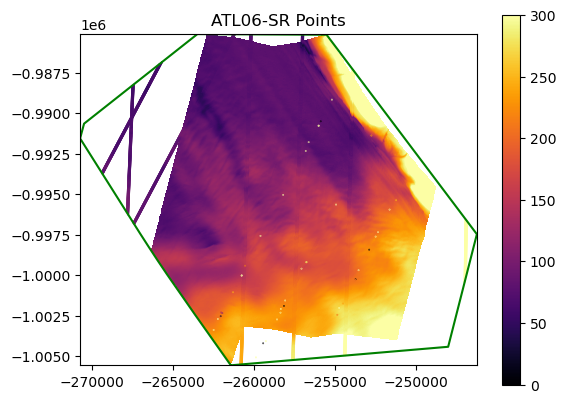

In [9]:
# %matplotlib widget

# Use the "poly" from SlideRule.toregion
x_poly = [list(i.values())[0] for i in region["poly"]]
y_poly = [list(i.values())[1] for i in region["poly"]]
gdf_poly = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[Polygon(zip(x_poly, y_poly))])
region_poly = gdf_poly.to_crs(3413)


f, ax = plt.subplots()

vmin = 0
vmax = 300

show(DEM, ax = ax, cmap = "inferno", vmin = vmin, vmax = vmax)

region_poly.boundary.plot(ax=ax, color = "green")
gdf_proj.plot(ax=ax, column='h_li', cmap='inferno', s=0.1, vmin = vmin, vmax = vmax, legend=True)

ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
plt.show()

In [10]:
## Get DEM elevation at location where it overlap with ATL06 time series

coords_IS2 = [(i.x, i.y) for i in gdf_proj["geometry"].values]
DEM_IS2 = np.asarray([sample[0] for sample in DEM.sample(coords_IS2)])
DEM_IS2[DEM_IS2 == -9999.] = np.nan

gdf_proj["DEM_height"] = DEM_IS2
gdf_proj_overlap = gdf_proj.dropna(subset=['DEM_height'])

gdf_proj_overlap["h_li_DEM_diff"] = gdf_proj_overlap["DEM_height"] - gdf_proj_overlap["h_li"]
gdf_proj_overlap

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,x_atc,dh_fit_dx,tide_ocean,atl06_quality_summary,bsnow_h,gt,r_eff,rgt,h_li,n_fit_photons,...,seg_azimuth,h_robust_sprd,segment_id,w_surface_window_final,cycle,y_atc,geometry,dem/geoid_h,DEM_height,h_li_DEM_diff
time,,,,,,,,,,,,,,,,,,,,,
2022-04-26 05:09:22.733939968,8.990311e+06,-0.022326,NaN,0,35.484779,10,0.811395,521,242.258926,378,...,-12.685022,0.764903,448653,4.589416,15,3308.833008,POINT (-260780.496 -1003804.53),17.394531,244.900925,2.641998
2022-04-26 05:09:22.736757248,8.990331e+06,0.037008,NaN,0,35.748711,10,0.763601,521,242.618134,358,...,-12.685230,0.732936,448654,4.397616,15,3308.762451,POINT (-260779.857 -1003784.999),17.393419,244.381241,1.763107
2022-04-26 05:09:22.739577088,8.990351e+06,-0.111735,NaN,0,36.012882,10,0.800196,521,241.248489,394,...,-12.685439,2.026756,448655,12.160535,15,3308.733643,POINT (-260779.253 -1003765.468),17.392328,244.381241,3.132751
2022-04-26 05:09:22.740361472,8.990591e+06,-0.043754,NaN,0,29.979246,50,0.642232,521,306.931427,283,...,-12.685499,0.393407,448667,3.000000,15,-3218.820557,POINT (-254400.227 -1003718.107),17.909256,308.055634,1.124207
2022-04-26 05:09:22.742399744,8.990371e+06,-0.000621,NaN,0,36.277321,10,0.839512,521,239.740921,413,...,-12.685657,2.040306,448656,12.241834,15,3308.730225,POINT (-260778.676 -1003745.935),17.391216,244.642670,4.901749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10 18:06:41.985763840,1.106910e+07,0.053491,NaN,0,49.955204,20,0.976792,743,94.886086,107,...,-167.188080,0.625453,552577,3.752720,15,3213.787109,POINT (-264463.976 -991160.537),16.425369,94.350578,-0.535507
2022-05-10 18:06:41.988572160,1.106912e+07,-0.049396,NaN,0,50.379112,20,0.762489,743,95.184746,101,...,-167.188293,1.416611,552578,8.499666,15,3213.773926,POINT (-264473.113 -991177.807),16.425373,94.350578,-0.834167
2022-05-10 18:06:41.991383040,1.106914e+07,0.022411,NaN,0,50.802116,20,0.796519,743,95.875671,128,...,-167.188507,3.186552,552579,19.119312,15,3213.774902,POINT (-264482.248 -991195.078),16.425381,95.996498,0.120827


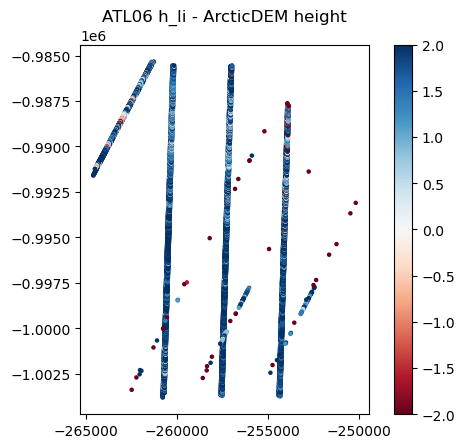

In [11]:
f, ax = plt.subplots()

vmin = -2
vmax = 2

gdf_proj_overlap.plot(ax=ax, column='h_li_DEM_diff', cmap='RdBu', s=5, vmin = vmin, vmax = vmax, legend=True)

ax.set_title("ATL06 h_li - ArcticDEM height")
ax.set_aspect('equal', adjustable='box')

plt.show()

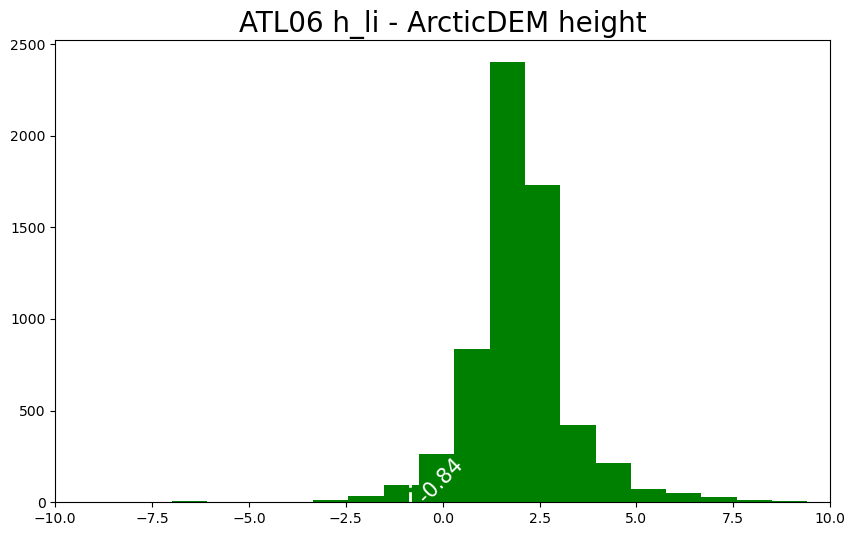

In [13]:
f, ax = plt.subplots(figsize = (10, 6))

num_bins = 2000
ax.hist(gdf_proj_overlap["h_li_DEM_diff"], num_bins, color ='green')

mean_diff = np.nanmean(gdf_proj_overlap["h_li_DEM_diff"].values)
ax.axvline(mean_diff, color='w', linestyle='dashed', linewidth=2)
plt.text(mean_diff+0.1, 0, str(np.round(mean_diff, 2)), rotation=45, color = "w", fontsize = 15)

ax.set_title("ATL06 h_li - ArcticDEM height", fontsize = 20)
plt.xlim([-10, 10]) 
plt.show()

In [26]:

diff = gdf_proj_overlap["h_li_DEM_diff"]
median_diff = np.median(diff)
std_diff = np.std(diff)

print("Median of DEM and ICESat-2 differences: ", median_diff)
print("Std of DEM and ICESat-2 differences: ", std_diff)

std_scalar = 1
# outlier_mask = (diff < median_diff-std_scalar*std_diff) | (diff > median_diff+std_scalar*std_diff)
outlier_mask = (diff < median_diff-5) | (diff > median_diff+5)
gdf_outlier = gdf_proj_overlap[outlier_mask].copy()

print("Total number of overlapping ICESat-2 data points: ", len(gdf_proj_overlap))
print("Number of outliers found: ", len(gdf_outlier))


Median of DEM and ICESat-2 differences:  1.9264374
Std of DEM and ICESat-2 differences:  53.805737
Total number of overlapping ICESat-2 data points:  6250
Number of outliers found:  114


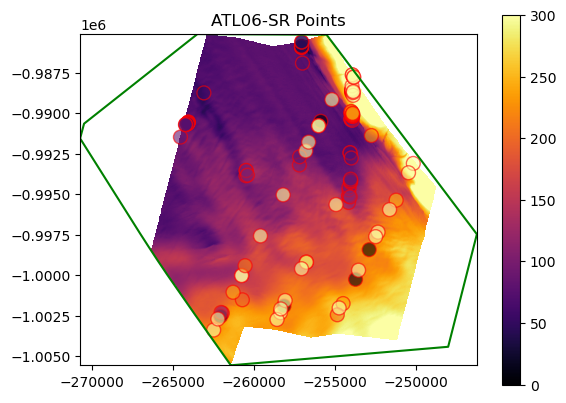

In [27]:
f, ax = plt.subplots()

vmin = 0
vmax = 300

show(DEM, ax = ax, cmap = "inferno", vmin = vmin, vmax = vmax)

region_poly.boundary.plot(ax=ax, color = "green")
gdf_outlier.plot(ax=ax, column='h_li', cmap='inferno', s=100, edgecolor = 'r', alpha = 0.6, vmin = vmin, vmax = vmax, legend=True)

ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
plt.show()

In [37]:
gdf_outlier.head()

,x_atc,dh_fit_dx,tide_ocean,atl06_quality_summary,bsnow_h,gt,r_eff,rgt,h_li,n_fit_photons,...,seg_azimuth,h_robust_sprd,segment_id,w_surface_window_final,cycle,y_atc,geometry,dem/geoid_h,DEM_height,h_li_DEM_diff
time,,,,,,,,,,,,,,,,,,,,,
2022-04-26 05:09:23.064008192,8.992652e+06,-0.207752,NaN,0,34.163425,10,0.550446,521,194.978073,281,...,-12.709712,4.520201,448770,27.121204,15,3309.252441,POINT (-260713.685 -1001519.218),17.270092,201.920792,6.942719
2022-04-26 05:09:23.924666112,8.998995e+06,-0.109103,NaN,0,29.979246,50,0.969570,521,120.653900,460,...,-12.774612,5.000000,449087,30.000000,15,-3219.054443,POINT (-254158.793 -995516.059),17.668692,129.138428,8.484528
2022-04-26 05:09:23.981110016,8.999395e+06,-0.092456,NaN,1,29.979246,50,0.884187,521,116.288795,422,...,-12.778901,5.000000,449107,30.000000,15,-3219.186035,POINT (-254147.132 -995125.512),17.656942,123.883629,7.594833
2022-04-26 05:09:23.986716672,8.999435e+06,-0.069999,NaN,0,29.979246,50,0.703537,521,112.644875,335,...,-12.779318,3.278929,449109,19.673573,15,-3219.087402,POINT (-254146.084 -995086.454),17.655766,120.817070,8.172195
2022-04-26 05:09:24.037406208,8.999795e+06,0.267684,NaN,0,29.979246,50,0.788221,521,104.466164,378,...,-12.783169,5.000000,449127,30.000000,15,-3219.195312,POINT (-254135.625 -994734.962),17.645277,111.883049,7.416885


In [36]:
np.unique(gdf_proj_overlap["atl06_quality_summary"].values)

array([0, 1], dtype=int8)

In [41]:
gdf_proj_overlap[gdf_proj_overlap["atl06_quality_summary"] == 1]

,x_atc,dh_fit_dx,tide_ocean,atl06_quality_summary,bsnow_h,gt,r_eff,rgt,h_li,n_fit_photons,...,seg_azimuth,h_robust_sprd,segment_id,w_surface_window_final,cycle,y_atc,geometry,dem/geoid_h,DEM_height,h_li_DEM_diff
time,,,,,,,,,,,,,,,,,,,,,
2022-04-26 05:09:23.021476864,8.992352e+06,-0.199583,NaN,1,50.101570,10,0.580499,521,214.920761,297,...,-12.706519,5.000000,448755,30.000000,15,3308.639648,POINT (-260721.681 -1001812.22),17.285679,219.554794,4.634033
2022-04-26 05:09:23.113319936,8.990651e+06,0.108395,NaN,1,43.258041,40,0.488347,521,235.689926,59,...,-12.713387,4.691246,448670,28.147476,15,-42.929676,POINT (-257498.769 -1003568.569),17.628502,238.482407,2.792480
2022-04-26 05:09:23.132770048,8.990671e+06,-0.102643,NaN,1,40.255852,20,0.728015,521,246.283569,88,...,-12.714865,5.000000,448671,30.000000,15,3216.607422,POINT (-260680.142 -1003455.574),17.381042,248.402786,2.119217
2022-04-26 05:09:23.180736768,8.991012e+06,-0.068361,NaN,1,44.733242,20,0.564296,521,243.968430,71,...,-12.718468,5.000000,448688,30.000000,15,3216.553223,POINT (-260670.315 -1003123.522),17.362782,245.838043,1.869614
2022-04-26 05:09:23.200432128,8.991152e+06,-0.235359,NaN,1,46.582897,20,0.647628,521,245.544586,80,...,-12.719939,5.000000,448695,30.000000,15,3216.597168,POINT (-260666.351 -1002986.793),17.355238,248.185867,2.641281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 18:14:59.320498432,1.108145e+07,0.225813,NaN,1,NaN,50,0.016550,682,25.658928,19,...,-167.290405,0.687552,553192,6.357206,15,-3207.437988,POINT (-262049.183 -1002529.541),17.235489,214.687363,189.028442
2022-05-06 18:14:59.382361856,1.107931e+07,-0.182368,NaN,1,NaN,40,0.154728,682,646.844116,34,...,-167.295029,0.743621,553085,8.854502,15,-37.603439,POINT (-258339.814 -1002083.651),17.489571,225.398071,-421.446045
2022-05-06 18:14:59.458694912,1.108243e+07,-0.558368,NaN,1,NaN,50,0.051095,682,323.977570,57,...,-167.300735,2.768234,553241,16.841877,15,-3207.157959,POINT (-262484.667 -1003382.134),17.261902,220.420609,-103.556961


In [33]:
sigma = gdf_proj_overlap["h_li_sigma"].values
print(np.median(sigma))
print(np.std(sigma))

0.11384401
0.2208053


In [34]:
sigma = gdf_outlier["h_li_sigma"].values
print(np.median(sigma))
print(np.std(sigma))

0.3555208
0.40261355
